In [160]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wine = load_wine()

wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine['data'], wine['target'], random_state=7196)

USPS_train_data = np.genfromtxt("zip.train", delimiter="")
USPS_test_data = np.genfromtxt("zip.test", delimiter="")

USPS_data = np.r_[USPS_train_data, USPS_test_data]
USPS_target = USPS_data[:,0]
USPS_data1 = USPS_data[:,1:257]

USPS_X_train, USPS_X_test, USPS_y_train, USPS_y_test = train_test_split(USPS_data1, USPS_target, random_state=7196)

In [161]:
def cal_cross_val_score(X_train, y_train, X_test, y_test):
    best_score = 0
    for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
        for C in [0.001, 0.01, 0.1, 1, 10, 100]:
            svm = SVC(gamma=gamma, C=C)
            scores = cross_val_score(svm, X_train, y_train, cv=5)
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_C = C
                best_gamma = gamma

    svm = SVC(C=best_C, gamma=best_gamma)
    svm.fit(X_train, y_train)

    print("The Generalization accuracy for 5-fold cross validation is : {}".format(best_score))
    print("Best parameters C and gamma:", best_C, best_gamma)
    test_score = svm.score(X_test, y_test)
    print("The test error rate is :", 1-test_score)

### Cross-validation accuracy and Test error rate for wine dataset:

In [162]:
cal_cross_val_score(wine_X_train, wine_y_train, wine_X_test, wine_y_test)

The Generalization accuracy for 5-fold cross validation is : 0.7817663817663817
Best parameters C and gamma: 100 0.001
The test error rate is : 0.2666666666666667


### Cross-Validation accuracy and Test error rate for USPS dataset:

In [164]:
cal_cross_val_score(USPS_X_train, USPS_y_train, USPS_X_test, USPS_y_test)

The Generalization accuracy for 5-fold cross validation is : 0.9741857319901472
Best parameters C and gamma: 10 0.01
The test error rate is : 0.021935483870967776


In [165]:
def define_pipeline(X_train, y_train, counter):
    if counter == 0:
        pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
    else:
        pipe = Pipeline([("scaler", Normalizer()), ("svm", SVC())])
    pipe.fit(X_train, y_train)   
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs = -1)
    grid.fit(X_train, y_train)
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    return grid

In [166]:
def cross_conformal_predictor(grid, X_train, y_train, X_test, y_test):
    rank_map = dict([])
    iterator = 0
    kf = KFold(n_splits=5, random_state=7196, shuffle=True)
    conformity_score_test = grid.decision_function(X_test)
    for rest_index, fold_index in kf.split(X_train):
        X_rest, X_fold = X_train[rest_index], X_train[fold_index]
        y_rest, y_fold = y_train[rest_index], y_train[fold_index]
        grid.fit(X_rest,y_rest)
        conformity_score_fold = grid.decision_function(X_fold)
        rank_array = []
        iterator = iterator+1
        for i in range(len(conformity_score_test)):
            conformity_score_fold_temp = np.vstack([conformity_score_fold,conformity_score_test[i]])
            df = pd.DataFrame(conformity_score_fold_temp)
            df1 = df.rank(method='max')
            test_sample_index = len(df1.index)-1
            rank_array.append(df1.iloc[[test_sample_index]].to_numpy())
        rank_map[iterator] = rank_array  

    final_rank_array = np.zeros((len(X_test),len(np.unique(y_test))))
    for i in range(1,len(rank_map.keys())+1):
        t_array = rank_map[i]
        for j in range(len(t_array)): 
            final_rank_array[j] = final_rank_array[j]+t_array[j]-1

    p_value_array = np.zeros((len(X_test),len(np.unique(y_test))))
    for i in range(len(final_rank_array)):
        p_value_array[i] = final_rank_array[i]+1
        p_value_array[i] = p_value_array[i]/(len(X_train)+1)
    
    return p_value_array

In [167]:
def plot_error_rate(X_test,y_test,p_value_array):
    eps = np.zeros(100) 
    err = np.zeros(100) 
    for k in range(100):
        eps[k] = k/100 
        err[k] = 0 
        for j in range(len(X_test)):
            if (p_value_array[j,int(y_test[j])] <= eps[k]): 
                err[k] = err[k] + 1 
        err[k] = err[k] / len(X_test) 
    plt.plot(eps,err)
    plt.xlabel('Significance level (ε)')
    plt.ylabel('percentage of errors')

### Cross-validation accuracy using GridSearchCV and Pipeline for wine dataset:

On experimenting with different types of normalization, I found MinMaxScaler to have the highest cross-validation accuracy and lowest test error rate for wine dataset for random state 7196. Hence, selecting MinMaxScaler as the function for data normalization. Also, another interesting observation which I noted was for different random states, the normalization values kept changing. 

In [168]:
print("-------------------MinMaxScaler----------------------")
grid_wine_minmax = define_pipeline(wine_X_train,wine_y_train, 0)
print("--------------------Normalizer-----------------------")
grid_wine_normalizer = define_pipeline(wine_X_train,wine_y_train, 1)

-------------------MinMaxScaler----------------------
Best cross-validation accuracy: 0.99
Best parameters: {'svm__C': 0.1, 'svm__gamma': 1}
--------------------Normalizer-----------------------
Best cross-validation accuracy: 0.95
Best parameters: {'svm__C': 100, 'svm__gamma': 100}


### Test error Rate using GridSearchCV and Pipeline for wine dataset:

In [169]:
print("Test error rate of wine dataset using MinMaxScaler: {:.2f}".format(1-grid_wine_minmax.score(wine_X_test, wine_y_test)))
print("Test error rate of wine dataset using Normalizer: {:.2f}".format(1-grid_wine_normalizer.score(wine_X_test, wine_y_test)))

Test error rate of wine dataset using MinMaxScaler: 0.07
Test error rate of wine dataset using Normalizer: 0.11


### Cross-validation accuracy using GridSearchCV and Pipeline for USPS dataset:

On experimenting with different types of normalization, I found Normalizer to have the highest cross-validation accuracy and lowest test error rate for USPS dataset. Hence, selecting Normalizer as the function for data normalization.

In [170]:
print("--------------------MinMaxScaler----------------------------")
grid_USPS_minmax = define_pipeline(USPS_X_train,USPS_y_train, 0)
print("---------------------Normalizer-----------------------------")
grid_USPS_normalizer = define_pipeline(USPS_X_train,USPS_y_train, 1)

--------------------MinMaxScaler----------------------------
Best cross-validation accuracy: 0.97
Best parameters: {'svm__C': 100, 'svm__gamma': 0.01}
---------------------Normalizer-----------------------------
Best cross-validation accuracy: 0.97
Best parameters: {'svm__C': 10, 'svm__gamma': 1}


### Test error Rate using GridSearchCV and Pipeline for USPS dataset:

In [171]:
print("Test error rate of USPS dataset using MinMaxScaler: {:.2f}".format(1-grid_USPS_minmax.score(USPS_X_test, USPS_y_test)))
print("Test error rate of USPS dataset using Normalizer: {:.2f}".format(1-grid_USPS_normalizer.score(USPS_X_test, USPS_y_test)))

Test error rate of USPS dataset using MinMaxScaler: 0.03
Test error rate of USPS dataset using Normalizer: 0.03


### Calibration-Curve plot of Cross-Conformal Predictor for wine dataset:

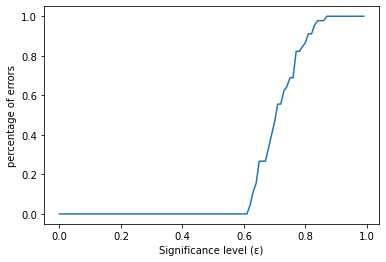

In [172]:
p_value_array_wine = cross_conformal_predictor(grid_wine_minmax,wine_X_train,wine_y_train,wine_X_test,wine_y_test)
plot_error_rate(wine_X_test, wine_y_test, p_value_array_wine)

### Calculating Average False P-Value for wine dataset:

In [173]:
sum_p_values = 0
for i in range(len(wine_y_test)):
    for j in range(len(p_value_array_wine[i])):
        sum_p_values = sum_p_values + p_value_array_wine[i][j]
    sum_p_values = sum_p_values - p_value_array_wine[i][wine_y_test[i]]
print("The average false p-value for wine dataset is : {:.2f}".format(sum_p_values/(2*(len(wine_y_test)))))

The average false p-value for wine dataset is : 0.47


### Calculating Cross-Conformal Predictor for USPS dataset:

In [174]:
p_value_array_USPS = cross_conformal_predictor(grid_USPS_normalizer,USPS_X_train,USPS_y_train,USPS_X_test,USPS_y_test)

### Calibration-Curve of Cross-Conformal Predictor for USPS dataset:

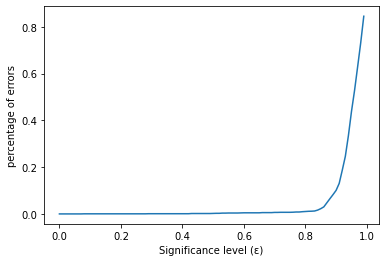

In [175]:
plot_error_rate(USPS_X_test, USPS_y_test, p_value_array_USPS)

### Calculating Average False P-Value for USPS dataset:

In [179]:
sum_p_values = 0
for i in range(len(USPS_y_test)):
    for j in range(len(p_value_array_USPS[i])):
        sum_p_values = sum_p_values + p_value_array_USPS[i][j]
    sum_p_values = sum_p_values - p_value_array_USPS[i][int(USPS_y_test[i])]
print("The average false p-value for USPS dataset is : {:.2f}".format(sum_p_values/(8*(len(USPS_y_test)))))

The average false p-value for USPS dataset is : 0.51
